In [61]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# Basic RNNs

## Generate the Dataset

In [62]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
  return series[..., np.newaxis].astype(np.float32)

In [63]:
np.random.seed(42)

In [64]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [65]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


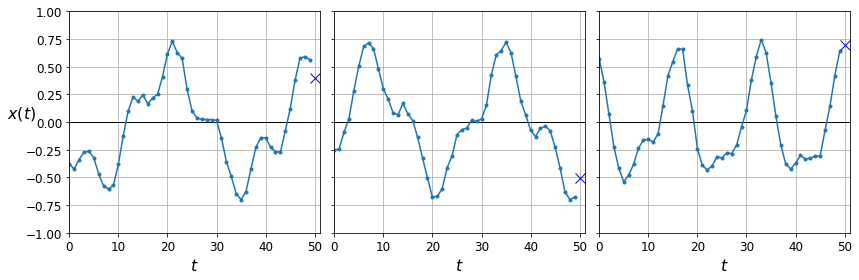

In [66]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$'):
  plt.plot(series, '.-')
  if y is not None:
    plt.plot(n_steps, y, 'bx', markersize=10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred, 'ro')
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + 1, -1, 1])
  
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$x(t)$' if col==0 else None))
save_fig('time_series_plot')

## Computing Some Baselines

In [67]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

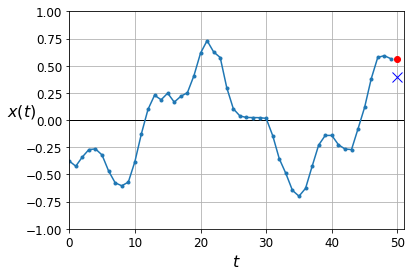

In [68]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [69]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[50, 1]),
  keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 61us/sample - loss: 0.1004 - val_loss: 0.0559
Epoch 2/20
7000/7000 [==============================] - 0s 61us/sample - loss: 0.0386 - val_loss: 0.0269
Epoch 3/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0205 - val_loss: 0.0162
Epoch 4/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0133 - val_loss: 0.0118
Epoch 5/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0104 - val_loss: 0.0098
Epoch 6/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 0s 29us/sample - loss: 0.0080 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
7000/7000 [==============================] - 0s 29us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 1

In [70]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 18us/sample - loss: 0.0041


0.004145486224442721

In [71]:
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)

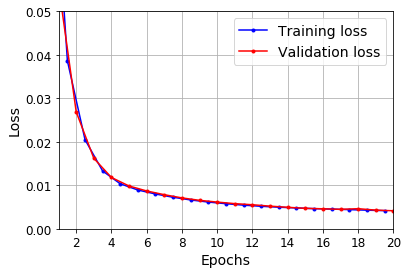

In [72]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

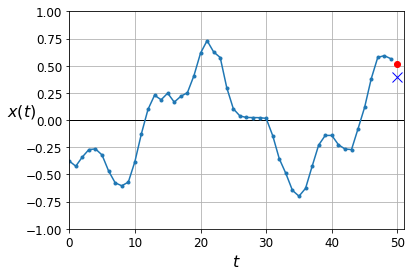

In [73]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

### Using a Simple RNN

In [74]:
np.random.seed(42)
tf.random.set_seed(42)

In [75]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [76]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 346us/sample - loss: 0.0972 - val_loss: 0.0491
Epoch 2/20
7000/7000 [==============================] - 2s 289us/sample - loss: 0.0372 - val_loss: 0.0298
Epoch 3/20
7000/7000 [==============================] - 2s 245us/sample - loss: 0.0255 - val_loss: 0.0220
Epoch 4/20
7000/7000 [==============================] - 2s 235us/sample - loss: 0.0200 - val_loss: 0.0178
Epoch 5/20
7000/7000 [==============================] - 2s 226us/sample - loss: 0.0167 - val_loss: 0.0152
Epoch 6/20
7000/7000 [==============================] - 2s 225us/sample - loss: 0.0147 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 2s 226us/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 2s 226us/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 2s 226us/sample - loss: 0.0119 - val_loss: 0.011

In [77]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 69us/sample - loss: 0.0109


0.010885455474257469

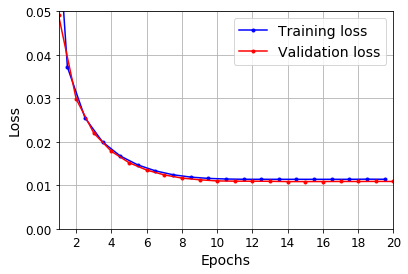

In [78]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

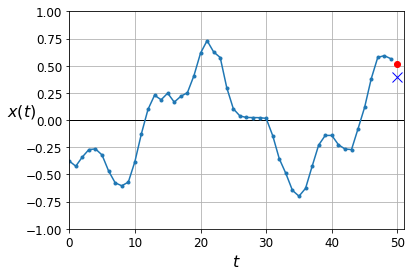

In [79]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

## Deep RNNs

In [80]:
np.random.seed(42)
tf.random.set_seed(42)

In [81]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20, return_sequences=True),
  keras.layers.SimpleRNN(1)
])

In [82]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 940us/sample - loss: 0.0433 - val_loss: 0.0073
Epoch 2/20
7000/7000 [==============================] - 5s 743us/sample - loss: 0.0066 - val_loss: 0.0052
Epoch 3/20
7000/7000 [==============================] - 5s 756us/sample - loss: 0.0051 - val_loss: 0.0043
Epoch 4/20
7000/7000 [==============================] - 6s 862us/sample - loss: 0.0045 - val_loss: 0.0044
Epoch 5/20
7000/7000 [==============================] - 6s 888us/sample - loss: 0.0040 - val_loss: 0.0038
Epoch 6/20
7000/7000 [==============================] - 6s 808us/sample - loss: 0.0038 - val_loss: 0.0042
Epoch 7/20
7000/7000 [==============================] - 5s 758us/sample - loss: 0.0037 - val_loss: 0.0033
Epoch 8/20
7000/7000 [==============================] - 5s 740us/sample - loss: 0.0036 - val_loss: 0.0035
Epoch 9/20
7000/7000 [==============================] - 6s 834us/sample - loss: 0.0034 - val_loss: 0.003

In [83]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 210us/sample - loss: 0.0029


0.00293410531245172

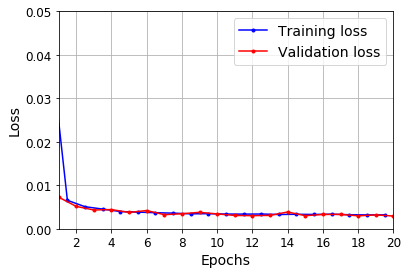

In [84]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

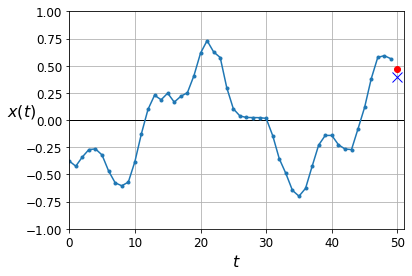

In [85]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

In [86]:
np.random.seed(42)
tf.random.set_seed(42)

In [87]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20),
  keras.layers.Dense(1)
])

In [88]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 768us/sample - loss: 0.0221 - val_loss: 0.0053
Epoch 2/20
7000/7000 [==============================] - 4s 547us/sample - loss: 0.0043 - val_loss: 0.0037
Epoch 3/20
7000/7000 [==============================] - 4s 542us/sample - loss: 0.0035 - val_loss: 0.0032
Epoch 4/20
7000/7000 [==============================] - 4s 546us/sample - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 4s 542us/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 4s 553us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
7000/7000 [==============================] - 4s 545us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 4s 547us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 9/20
7000/7000 [==============================] - 4s 553us/sample - loss: 0.0030 - val_loss: 0.002

In [89]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 134us/sample - loss: 0.0026


0.0025768046267330646

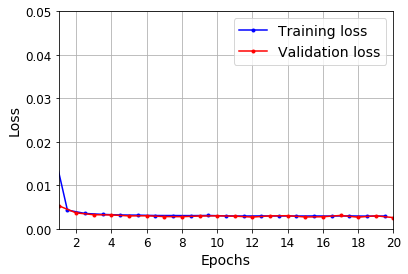

In [90]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

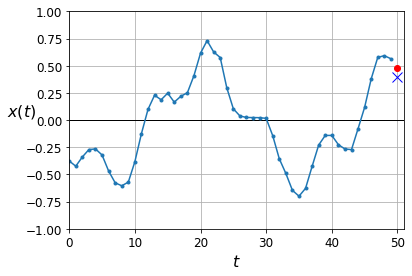

In [91]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [92]:
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)
  
Y_pred = X[:, n_steps:]

In [93]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


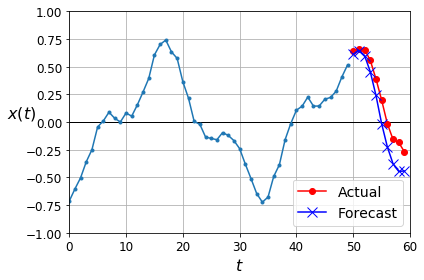

In [94]:
def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
  plt.axis([0, n_steps + ahead, -1, 1])
  plt.legend(fontsize=14)
  
plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig('forecast_ahead_plot')

In [95]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_vaid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000, -10:, 0]

In [96]:
X = X_valid
for step_ahead in range(10):
  y_pred_one = model.predict(X)[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)
  
Y_pred = X[:, n_steps:, 0]

In [97]:
Y_pred.shape

(2000, 10)

In [98]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.44802427

In [99]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [100]:
np.random.seed(42)
tf.random.set_seed(42)

In [101]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[50, 1]),
  keras.layers.Dense(10)
])

In [102]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 70us/sample - loss: 0.1348 - val_loss: 0.3150
Epoch 2/20
7000/7000 [==============================] - 0s 36us/sample - loss: 0.0501 - val_loss: 0.3525
Epoch 3/20
7000/7000 [==============================] - 0s 33us/sample - loss: 0.0388 - val_loss: 0.3764
Epoch 4/20
7000/7000 [==============================] - 0s 35us/sample - loss: 0.0334 - val_loss: 0.3950
Epoch 5/20
7000/7000 [==============================] - 0s 37us/sample - loss: 0.0299 - val_loss: 0.4013
Epoch 6/20
7000/7000 [==============================] - 0s 37us/sample - loss: 0.0275 - val_loss: 0.4117
Epoch 7/20
7000/7000 [==============================] - 0s 34us/sample - loss: 0.0258 - val_loss: 0.4194
Epoch 8/20
7000/7000 [==============================] - 0s 38us/sample - loss: 0.0245 - val_loss: 0.4256
Epoch 9/20
7000/7000 [==============================] - 0s 37us/sample - loss: 0.0235 - val_loss: 0.4362
Epoch 1

In [103]:
np.random.seed(42)
tf.random.set_seed(42)

In [104]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), 
  keras.layers.SimpleRNN(20),
  keras.layers.Dense(10)
])

In [105]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 685us/sample - loss: 0.0665 - val_loss: 0.4001
Epoch 2/20
7000/7000 [==============================] - 4s 535us/sample - loss: 0.0268 - val_loss: 0.4366
Epoch 3/20
7000/7000 [==============================] - 4s 532us/sample - loss: 0.0188 - val_loss: 0.4442
Epoch 4/20
7000/7000 [==============================] - 4s 522us/sample - loss: 0.0159 - val_loss: 0.4472
Epoch 5/20
7000/7000 [==============================] - 4s 523us/sample - loss: 0.0138 - val_loss: 0.4698
Epoch 6/20
7000/7000 [==============================] - 4s 526us/sample - loss: 0.0132 - val_loss: 0.4687
Epoch 7/20
7000/7000 [==============================] - 4s 526us/sample - loss: 0.0119 - val_loss: 0.4564
Epoch 8/20
7000/7000 [==============================] - 4s 529us/sample - loss: 0.0115 - val_loss: 0.4519
Epoch 9/20
7000/7000 [==============================] - 4s 530us/sample - loss: 0.0110 - val_loss: 0.477

In [108]:
np.random.seed(43)
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

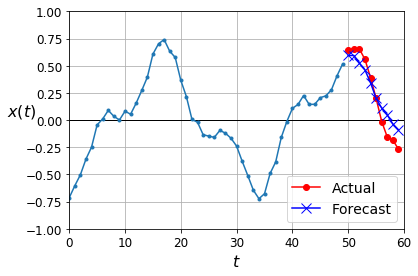

In [109]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

In [112]:
np.random.seed(42)

In [113]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
  Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [115]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [117]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
  
])

In [118]:
def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 747us/sample - loss: 0.0498 - last_time_step_mse: 0.0388 - val_loss: 0.0416 - val_last_time_step_mse: 0.0321
Epoch 2/20
7000/7000 [==============================] - 4s 534us/sample - loss: 0.0388 - last_time_step_mse: 0.0281 - val_loss: 0.0332 - val_last_time_step_mse: 0.0223
Epoch 3/20
7000/7000 [==============================] - 4s 548us/sample - loss: 0.0321 - last_time_step_mse: 0.0208 - val_loss: 0.0304 - val_last_time_step_mse: 0.0196
Epoch 4/20
7000/7000 [==============================] - 4s 568us/sample - loss: 0.0294 - last_time_step_mse: 0.0182 - val_loss: 0.0278 - val_last_time_step_mse: 0.0165
Epoch 5/20
7000/7000 [==============================] - 5s 648us/sample - loss: 0.0271 - last_time_step_mse: 0.0153 - val_loss: 0.0262 - val_last_time_step_mse: 0.0141
Epoch 6/20
7000/7000 [==============================] - 4s 577us/sample - loss: 0.0245 - last_time_step_mse: 0.0

In [119]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

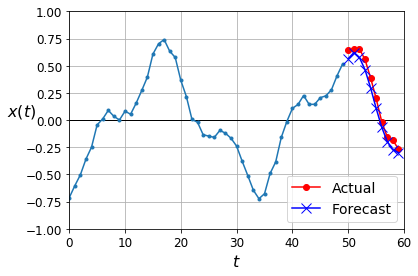

In [120]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

# Deep RNN with Batch Norm

In [121]:
np.random.seed(42)
tf.random.set_seed(42)

In [122]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.BatchNormalization(),
  keras.layers.SimpleRNN(20, return_sequences=True),
  keras.layers.BatchNormalization(),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [124]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 770us/sample - loss: 0.1936 - last_time_step_mse: 0.1913 - val_loss: 0.0901 - val_last_time_step_mse: 0.0863
Epoch 2/20
7000/7000 [==============================] - 4s 539us/sample - loss: 0.0531 - last_time_step_mse: 0.0441 - val_loss: 0.0559 - val_last_time_step_mse: 0.0469
Epoch 3/20
7000/7000 [==============================] - 4s 544us/sample - loss: 0.0470 - last_time_step_mse: 0.0374 - val_loss: 0.0453 - val_last_time_step_mse: 0.0354
Epoch 4/20
7000/7000 [==============================] - 4s 545us/sample - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0423 - val_last_time_step_mse: 0.0320
Epoch 5/20
7000/7000 [==============================] - 4s 550us/sample - loss: 0.0414 - last_time_step_mse: 0.0310 - val_loss: 0.0402 - val_last_time_step_mse: 0.0301
Epoch 6/20
7000/7000 [==============================] - 4s 553us/sample - loss: 0.0390 - last_time_step_mse: 0.0

# Deep RNNs with Layer Norm

In [125]:
from tensorflow.keras.layers import LayerNormalization

In [128]:
class LNSimpleRNNCell(keras.layers.Layer):
  def __init__(self, units, activation='tanh', **kwargs):
    super().__init__(**kwargs)
    self.state_size = units
    self.output_size = units
    self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
    self.layer_norm = LayerNormalization()
    self.activation = keras.activations.get(activation)
    
  def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    if inputs is not None:
      batch_size = tf.shape(inputs)[0]
      dtype = inputs.dtype
    return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
  
  def call(self, inputs, states):
    outputs, new_states = self.simple_rnn_cell(inputs, states)
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs]

In [129]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
  keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [130]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.1539 - last_time_step_mse: 0.1506 - val_loss: 0.0701 - val_last_time_step_mse: 0.0641
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0627 - last_time_step_mse: 0.0555 - val_loss: 0.0568 - val_last_time_step_mse: 0.0495
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0540 - last_time_step_mse: 0.0463 - val_loss: 0.0502 - val_last_time_step_mse: 0.0423
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0472 - last_time_step_mse: 0.0385 - val_loss: 0.0434 - val_last_time_step_mse: 0.0336
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0419 - last_time_step_mse: 0.0320 - val_loss: 0.0394 - val_last_time_step_mse: 0.0292
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0382 - last_time_step_mse: 0.0272 - val_l

# Creating a Custom RNN Class

In [144]:
class MyRNN(keras.layers.Layer):
  def __init__(self, cell, return_sequences=False, **kwargs):
    super().__init__(**kwargs)
    self.cell = cell
    self.return_sequences = return_sequences
    self.get_initial_state = getattr(self.cell, 'get_initial_state', self.fallback_initial_state)
    
  def fallback_initial_state(self, inputs):
    return [tf.zeros([self.cell.state.size], dtype=inputs.dtype)]
  
  @tf.function
  def call(self, inputs):
    states = self.get_initial_state(inputs)
    n_steps = tf.shape(inputs)[1]
    if self.return_sequences:
      sequences = tf.TensorArray(inputs.dtype, size=n_steps)
    outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
    for step in tf.range(n_steps):
      outputs, states = self.cell(inputs[:, step], states)
      if self.return_sequences:
        sequences = sequences.write(step, outputs)
    if self.return_sequences:
      return sequences.stack()
    else:
      return outputs

In [145]:
np.random.seed(42)
tf.random.set_seed(42)

In [146]:
model = keras.models.Sequential([
  MyRNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
  MyRNN(LNSimpleRNNCell(20), return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [148]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.2208 - last_time_step_mse: 0.2084 - val_loss: 0.0874 - val_last_time_step_mse: 0.0761
Epoch 2/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0724 - last_time_step_mse: 0.0604 - val_loss: 0.0628 - val_last_time_step_mse: 0.0508
Epoch 3/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0577 - last_time_step_mse: 0.0439 - val_loss: 0.0537 - val_last_time_step_mse: 0.0389
Epoch 4/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0506 - last_time_step_mse: 0.0363 - val_loss: 0.0485 - val_last_time_step_mse: 0.0327
Epoch 5/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0460 - last_time_step_mse: 0.0317 - val_loss: 0.0444 - val_last_time_step_mse: 0.0298
Epoch 6/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0428 - last_time_step_mse: 0.0287 - val_lo

# LSTMs

In [150]:
np.random.seed(42)
tf.random.set_seed(42)

In [151]:
model = keras.models.Sequential([
  keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.LSTM(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [153]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0372
Epoch 2/20
7000/7000 [==============================] - 7s 980us/sample - loss: 0.0480 - last_time_step_mse: 0.0281 - val_loss: 0.0423 - val_last_time_step_mse: 0.0211
Epoch 3/20
7000/7000 [==============================] - 7s 986us/sample - loss: 0.0390 - last_time_step_mse: 0.0182 - val_loss: 0.0371 - val_last_time_step_mse: 0.0164
Epoch 4/20
7000/7000 [==============================] - 7s 979us/sample - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0335 - val_last_time_step_mse: 0.0143
Epoch 5/20
7000/7000 [==============================] - 7s 983us/sample - loss: 0.0325 - last_time_step_mse: 0.0136 - val_loss: 0.0314 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 7s 976us/sample - loss: 0.0308 - last_time_step_mse: 0.012

In [154]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 200us/sample - loss: 0.0240 - last_time_step_mse: 0.0086


[0.024016654595732687, 0.00855141]

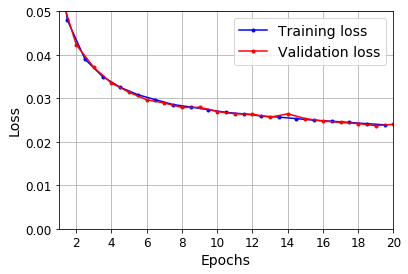

In [156]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])


In [157]:
np.random.seed(43)

In [158]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

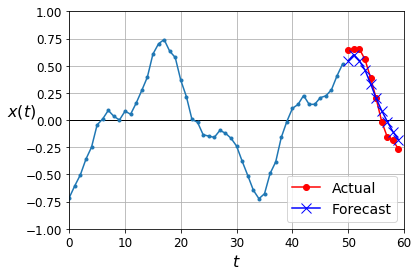

In [159]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)


# GRUs

In [160]:
np.random.seed(42)
tf.random.set_seed(42)

In [161]:
model = keras.models.Sequential([
  keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.GRU(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [162]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0742 - last_time_step_mse: 0.0663 - val_loss: 0.0523 - val_last_time_step_mse: 0.0421
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0327
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0418 - last_time_step_mse: 0.0305 - val_loss: 0.0391 - val_last_time_step_mse: 0.0271
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0373 - last_time_step_mse: 0.0249 - val_loss: 0.0343 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0327 - last_time_step_mse: 0.0179 - val_loss: 0.0313 - val_last_time_step_mse: 0.0158
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0308 - last_time_step_mse: 0.0155 - val_l

In [163]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 214us/sample - loss: 0.0241 - last_time_step_mse: 0.0103


[0.02407100349664688, 0.010298318]

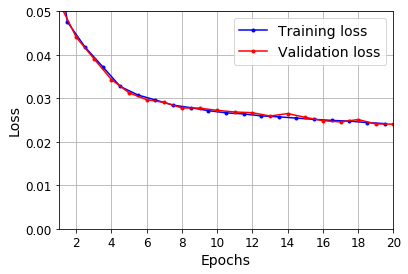

In [164]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [165]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

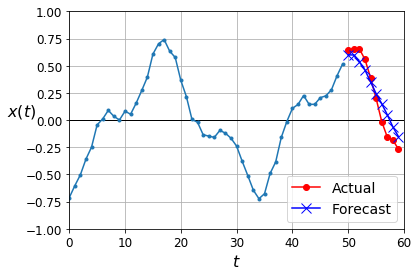

In [166]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

## Using One-Dimensional Convolutional Layers to Process Sequences

In [167]:
np.random.seed(42)
tf.random.set_seed(42)

In [168]:
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', input_shape=[None, 1]), 
  keras.layers.GRU(20, return_sequences=True),
  keras.layers.GRU(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [170]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0683 - last_time_step_mse: 0.0605 - val_loss: 0.0482 - val_last_time_step_mse: 0.0405
Epoch 2/20
7000/7000 [==============================] - 5s 660us/sample - loss: 0.0416 - last_time_step_mse: 0.0342 - val_loss: 0.0368 - val_last_time_step_mse: 0.0283
Epoch 3/20
7000/7000 [==============================] - 4s 638us/sample - loss: 0.0334 - last_time_step_mse: 0.0251 - val_loss: 0.0307 - val_last_time_step_mse: 0.0220
Epoch 4/20
7000/7000 [==============================] - 4s 630us/sample - loss: 0.0273 - last_time_step_mse: 0.0172 - val_loss: 0.0251 - val_last_time_step_mse: 0.0141
Epoch 5/20
7000/7000 [==============================] - 4s 639us/sample - loss: 0.0243 - last_time_step_mse: 0.0134 - val_loss: 0.0238 - val_last_time_step_mse: 0.0128
Epoch 6/20
7000/7000 [==============================] - 5s 647us/sample - loss: 0.0230 - last_time_step_mse: 0.012

In [171]:
np.random.seed(42)
tf.random.set_seed(42)

In [173]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
  model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu', dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 316us/sample - loss: 0.0684 - last_time_step_mse: 0.0550 - val_loss: 0.0387 - val_last_time_step_mse: 0.0248
Epoch 2/20
7000/7000 [==============================] - 2s 219us/sample - loss: 0.0342 - last_time_step_mse: 0.0216 - val_loss: 0.0307 - val_last_time_step_mse: 0.0182
Epoch 3/20
7000/7000 [==============================] - 2s 220us/sample - loss: 0.0293 - last_time_step_mse: 0.0172 - val_loss: 0.0275 - val_last_time_step_mse: 0.0152
Epoch 4/20
7000/7000 [==============================] - 2s 220us/sample - loss: 0.0270 - last_time_step_mse: 0.0149 - val_loss: 0.0259 - val_last_time_step_mse: 0.0140
Epoch 5/20
7000/7000 [==============================] - 2s 245us/sample - loss: 0.0254 - last_time_step_mse: 0.0133 - val_loss: 0.0248 - val_last_time_step_mse: 0.0126
Epoch 6/20
7000/7000 [==============================] - 2s 226us/sample - loss: 0.0245 - last_time_step_mse: 0.0

In [174]:
class GateActivationUnit(keras.layers.Layer):
  def __init__(self, activation='tanh', **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
  def call(self, inputs):
    n_filters = inputs.shape[-1] // 2
    linear_output = self.activation(inputs[..., :n_filters])
    gate = keras.activations.sigmoid(inputs[..., n_filters:])
    return self.activation(linear_output) * gate

In [175]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
  z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding='causal', dilation_rate=dilation_rate)(inputs)
  z = GateActivationUnit()(z)
  z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
  return keras.layers.Add()([z, inputs]), z

In [176]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [179]:
n_layers_per_block = 3
n_blocks = 1
n_filters = 32
n_outputs = 10

In [181]:
inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding='causal')(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
  z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
  skip_to_last.append(skip)
  
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation='relu')(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation='softmax')(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [182]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 3s 406us/sample - loss: 0.1293 - last_time_step_mse: 0.1252 - val_loss: 0.1227 - val_last_time_step_mse: 0.1197
Epoch 2/2
7000/7000 [==============================] - 2s 311us/sample - loss: 0.1221 - last_time_step_mse: 0.1177 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189
